# Benchmark comparison of protein sequence preprocessing effect on learning task for Pfam family classification

Notebook below allows to play with parameters of the workflow and yield different results.
As a default state it is set with parameters described in the paper as well as used as a base for plots.

In [44]:
import os

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, interact_manual, fixed
import sys
from urllib import request
from scripts.data_preparation_support import data_preparation, split_to_train_test
from scripts.shorten_encoding import compress_protein_data_original, compress_protein_data_singletons, compress_protein_data_triplets, compress_protein_data_sum_of_triplets, compress_protein_data_sum_of_k_mers
from scripts.prepare_vectors import split_data_to_classes, prepare_biovec_model, load_biovec_model_with_classes
from scripts.prepare_input_stats import input_analysis
from scripts.model_scripts.decision_trees import decision_tree_func
from scripts.model_scripts.random_tree import random_tree_func
from scripts.model_scripts.mlp import mlp_func
from scripts.model_scripts.nearest_neighbours import nearest_neighbours_func
from scripts.model_scripts.deep_learning import deep_learning_func
from scripts.plotting_support import results_plot_benchmark, plot_sizes
from time import time

## Dataset
In this project I provide already prepared - cleaned dataset used for the report, so download part below is commented out. However, if desired, parameters can be tweaked to obtain altered version.

Raw data for this project is easily accessible by the Swissprot part of the Uniprot Database.
Unfortunately, full file weights around 250Mb, so instead I provide link for download.

In case server can't handle the download through Python, it is still possiblle to download tab-separated file directly
from the website: [LINK](https://www.uniprot.org/uniprot/?query=reviewed%3Ayes&columns=id%2Cdatabase(Pfam)%2Corganism%2Csequence)

It suggested, although not neccessary, to put downloaded file into ./data/full directory for clarity and ease of use of the default values below.

In [4]:
# url="https://www.uniprot.org/uniprot/?query=reviewed:yes&format=tab&columns=id,database(Pfam),organism,sequence"
# request.urlretrieve(url, "./data/full/uniprot-reviewed_yes.tab")

In [5]:
def data_prepare_widget():
    org_w = widgets.BoundedIntText(value=2000, min=1, max=5000, step=1, description="Organisms")
    fam_w = widgets.BoundedIntText(value=10, min=1, max=200, step=1, description="Families")
    infile = widgets.Text(value="./data/full/uniprot-reviewed_yes.tab",  description="Input path")
    outfile = widgets.Text(value="./data/data_file.fasta", description="Output path")

    widget = interact_manual.options(manual_name="Prepare data")
    widget(data_preparation, n_org=org_w, n_fam=fam_w, file_path=infile, outfile_path=outfile)

In [6]:
data_prepare_widget()

interactive(children=(Text(value='./data/full/uniprot-reviewed_yes.tab', description='Input path'), Text(value…

At this point of code raw Swissprot data was filtered by the top number of organisms and picked proteins containing single domain from top biggest families.

However, before splitting our data to train and test, we want to first adress very simmilar sequences.
It can be done using CD-HIT package.

In [7]:
def run_cdhit(input_f="./data/to_cluster/data_file.fasta", output_f="./data/to_cluster/data_file_outttt.fasta", c="0.99"):
    c = str(c)
    print("Begin CD-HIT")
    os.system(f"./CD-HIT/cd-hit -i {input_f} -o {output_f} -c {c}")


def run_cdhit_widget():
    c = widgets.BoundedFloatText(value=0.99, min=0.7, max=1, description="Simmilarity")
    infile = widgets.Text(value="./data/data_file.fasta",  description="Input path")
    outfile = widgets.Text(value="./data/clustering/data_file_clustered.fasta", description="Output path")

    widget = interact_manual.options(manual_name="Prepare data")
    widget(run_cdhit, c=c, input_f=infile, output_f=outfile)

In [8]:
run_cdhit_widget()

interactive(children=(Text(value='./data/data_file.fasta', description='Input path'), Text(value='./data/clust…

Now our data is cleaned out and ready to process.

## Data processing

For this project data is processed in multiple ways.

 - Standard single-letter encoding
 - Conversion into numbers and using int-8 encoding
 - Conversion into 3-mers, encoding each 3-mer as a number and using int-16 encoding
 - Conversion into 3-mers, calculating count of the most popular triplets in sequences.
 - Conversion into k-mers, grouping with allowed edit distance and counting existance of fragments in group. (7-mers with edit distance 3)
 - Using Biovec vector encoder

First we need to split our data into training and test parts.
To avoid dominance of the biggest families, training data will contain the same number of sequences for each PFAM family.

### Warning!
Please analyse the histogram first before providing number of sequences per family to train.
Families with number of representatives lower than provided will be filtered out!

Sometimes it might be beneficial to filter out couple families with low coverage.

In [12]:
def histogram_widget():
    infile = widgets.Text(value="./data/clustering/data_file_clustered.fasta",  description="Input path")
    widget = interact_manual.options(manual_name="Prepare histogram")

    widget(input_analysis, input_file=infile)

In [13]:
histogram_widget()

interactive(children=(Text(value='./data/clustering/data_file_clustered.fasta', description='Input path'), But…

In [14]:
def split_to_train_test_widget():
    train_val = widgets.BoundedIntText(value=790, min=1, max=5000, step=1, description="N. to train")
    infile = widgets.Text(value="./data/clustering/data_file_clustered.fasta",  description="Input path")
    outfile = widgets.Text(value="./data/clean_dataset.pkl", description="Output path")

    widget = interact_manual.options(manual_name="Prepare data")
    new_val = widget(split_to_train_test, train_val=train_val, infile=infile, outfile=outfile)
    return new_val

In [15]:
train_val_global = split_to_train_test_widget()

interactive(children=(BoundedIntText(value=650, description='N. to train', max=5000, min=1), Text(value='./dat…

This process will save data into convenient pickle object. This way instead of keeping 4 separate files or trying to split our data in one file we can easily load a list prepared to use.

In [16]:
compress_protein_data_original(infile='./data/clean_dataset.pkl', outfile='./data/clean_dataset_original.pkl')

In [17]:
compress_protein_data_singletons(infile='./data/clean_dataset.pkl', outfile='./data/clean_dataset_singletons.pkl')

In [18]:
compress_protein_data_triplets(infile='./data/clean_dataset.pkl', outfile='./data/clean_dataset_triplets.pkl')

In [ ]:
compress_protein_data_sum_of_triplets(infile='./data/clean_dataset.pkl', outfile='./data/clean_dataset_sum_triplets.pkl')

## Shorten sum k-mer

Plugin below allows for customized summed k-mer encoding. Parameters:

- input, output files
- K-mer length - size of the moving, overalpping window
- Min. occurences - How many times certain k-mer must exist in all sequences to be taken into consideration (filtering out highly mutated fragments, picking "popularity" strength)
- Allowed edit distance - Fragments with edit distance equal or lower than provided to already found fragments will be united into one group. Example: with value 1 strings: AAAAA and AAAAB will be united while AAAAA and AAABB treated as separate groups.

In [ ]:
def shorten_kmer_widget():
    infile = widgets.Text(value="./data/clean_dataset.pkl",  description="Input path")
    outfile = widgets.Text(value="./data/clean_dataset_sum_k_mers.pkl", description="Output path")
    n_val = widgets.BoundedIntText(value=7, min=3, max=15, step=1, description="k-mer length")
    k_val = widgets.BoundedIntText(value=20, min=1, max=1000, step=1, description="min. occurences")
    edit_val = widgets.BoundedIntText(value=2, min=1, max=3, step=1, description="allowed edit distance")

    widget = interact_manual.options(manual_name="Prepare data")
    widget(compress_protein_data_sum_of_k_mers, n=n_val, k=k_val, edit=edit_val, infile=infile, outfile=outfile)

In [ ]:
shorten_kmer_widget()

## Biovec

Biovec model is built on top of the original implementation, thus data handling must be a bit different, to fit authors requirements.
Sequences must be split into class fasta files, and one combined with identical names.
Combined file will be used to generate model, wchich will be then saved.
This saved model, is next loaded again, but this time, we also provide family information.

After this procedure we are finally left with a data ready to split into training and test, perform learning and predictions.


### Warning !
This time widget is not provided, because of the ./data/vectors/combined_corpus.fasta file.
If Biovec recognizes this file it will skip creating a new model.
That's why paths here are fixed to ensure, old corpus file is deleted.

### Warning !
It might happen, that during loading process there will be information, that model did not train on certain triplets.
It is connected with fragments containing extended alphabet like "X" and are ignored.

In [20]:
split_data_to_classes(infile="./data/clean_dataset.pkl", output_folder="./data/vectors/class_folder",
                          output_combined_file="./data/vectors/combined.fasta")

In [21]:
prepare_biovec_model(infile="./data/vectors/combined.fasta", outfile="./data/vectors/ProtVec_model.model")

In [22]:
def load_biovec_widget():
    train_val = widgets.BoundedIntText(value=790, min=1, max=5000, step=1, description="N. to train")

    widget = interact_manual.options(manual_name="Prepare data")

    new_val = widget(load_biovec_model_with_classes, train_size=train_val, input_model=fixed("./data/vectors/ProtVec_model.model"), class_folder=fixed("./data/vectors/class_folder"), outfile=fixed('./data/clean_dataset_biovec.pkl'))

In [23]:
load_biovec_widget()

interactive(children=(BoundedIntText(value=650, description='N. to train', max=5000, min=1), Button(descriptio…

## Evaluation

Now, that we have all data prepared, we can evaluate them both in accuracy and runtime.

Several models will be created - please note, that not all of them are equally suitable for this kind of data - the point is in efficiency comparison.

- Decision trees
- Random trees
- Nearest Neighbours
- MLP
- Simple Machine Learning with Dense layers

In [28]:
all_times = []
all_accs = []

In [29]:
s1 = time()
acc1 = decision_tree_func("./data/clean_dataset_original.pkl")
t1 = time() - s1

s2 = time()
acc2 = decision_tree_func("./data/clean_dataset_singletons.pkl")
t2 = time() - s2

s3 = time()
acc3 = decision_tree_func("./data/clean_dataset_triplets.pkl")
t3 = time() - s3

s4 = time()
acc4 = decision_tree_func("./data/clean_dataset_sum_triplets.pkl")
t4 = time() - s4

s5 = time()
acc5 = decision_tree_func("./data/clean_dataset_sum_k_mers.pkl")
t5 = time() - s5

s6 = time()
acc6 = decision_tree_func("./data/clean_dataset_biovec.pkl")
t6 = time() - s6

t1 = round(t1, 2)
t2 = round(t2, 2)
t3 = round(t3, 2)
t4 = round(t4, 2)
t5 = round(t5, 2)
t6 = round(t6, 2)

all_times.append([t1, t2, t3, t4, t5, t6])
all_accs.append([acc1, acc2, acc3, acc4, acc5, acc6])

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best model:
- max_depth: 100
----- Model accuracy: 0.189
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best model:
- max_depth: 60
----- Model accuracy: 0.705
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best model:
- max_depth: 10
----- Model accuracy: 0.652
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best model:
- max_depth: 50
----- Model accuracy: 0.827
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best model:
- max_depth: 100
----- Model accuracy: 0.31
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best model:
- max_depth: 30
----- Model accuracy: 0.709


In [30]:
print(f"Statistic | Original | Singletons | Triplets | Sum Triplets | Sum K-mers | Biovec")
print(f"----------|----------|------------|----------|--------------|------------|--------")
print(f"Time      | {t1} \t | {t2} \t | {t3} \t | {t4} \t | {t5} \t | {t6} \t")
print(f"Accuracy  | {acc1} \t | {acc2} \t | {acc3} \t | {acc4} \t | {acc5} \t | {acc6} \t")

Statistic | Original | Singletons | Triplets | Sum Triplets | Sum K-mers | Biovec
----------|----------|------------|----------|--------------|------------|--------
Time      | 16.07 	 | 10.66 	 | 6.54 	 | 22.6 	 | 47.2 	 | 0.39 	
Accuracy  | 0.1886 	 | 0.7048 	 | 0.6524 	 | 0.8267 	 | 0.3105 	 | 0.7089 	


In [31]:
s1 = time()
acc1 = random_tree_func("./data/clean_dataset_original.pkl")
t1 = time() - s1

s2 = time()
acc2 = random_tree_func("./data/clean_dataset_singletons.pkl")
t2 = time() - s2

s3 = time()
acc3 = random_tree_func("./data/clean_dataset_triplets.pkl")
t3 = time() - s3

s4 = time()
acc4 = random_tree_func("./data/clean_dataset_sum_triplets.pkl")
t4 = time() - s4

s5 = time()
acc5 = random_tree_func("./data/clean_dataset_sum_k_mers.pkl")
t5 = time() - s5

s6 = time()
acc6 = random_tree_func("./data/clean_dataset_biovec.pkl")
t6 = time() - s6

t1 = round(t1, 2)
t2 = round(t2, 2)
t3 = round(t3, 2)
t4 = round(t4, 2)
t5 = round(t5, 2)
t6 = round(t6, 2)

all_times.append([t1, t2, t3, t4, t5, t6])
all_accs.append([acc1, acc2, acc3, acc4, acc5, acc6])

Fitting 2 folds for each of 15 candidates, totalling 30 fits
Best model:
- random_state: 1234
- max_depth: 20
- max_features: 20
----- Model accuracy: 0.419
Fitting 2 folds for each of 15 candidates, totalling 30 fits
Best model:
- random_state: 1234
- max_depth: 30
- max_features: 20
----- Model accuracy: 0.802
Fitting 2 folds for each of 15 candidates, totalling 30 fits
[CV 2/2] END ......................max_depth=10;, score=0.616 total time=   0.9s
[CV 1/2] END ......................max_depth=20;, score=0.641 total time=   1.0s
[CV 1/2] END ......................max_depth=30;, score=0.643 total time=   0.9s
[CV 1/2] END ......................max_depth=40;, score=0.646 total time=   0.9s
[CV 1/2] END ......................max_depth=50;, score=0.637 total time=   0.9s
[CV 1/2] END ......................max_depth=60;, score=0.641 total time=   0.9s
[CV 1/2] END ......................max_depth=70;, score=0.645 total time=   0.9s
[CV 1/2] END ......................max_depth=80;, score=0.

Best model:
- random_state: 1234
- max_depth: 30
- max_features: 20
----- Model accuracy: 0.788
Fitting 2 folds for each of 15 candidates, totalling 30 fits
Best model:
- random_state: 1234
- max_depth: 50
- max_features: 20
----- Model accuracy: 0.978
Fitting 2 folds for each of 15 candidates, totalling 30 fits
Best model:
- random_state: 1234
- max_depth: 50
- max_features: 15
----- Model accuracy: 0.342
Fitting 2 folds for each of 15 candidates, totalling 30 fits


/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best model:
- random_state: 1234
- max_depth: 10
- max_features: 15
----- Model accuracy: 0.884


In [32]:
print(f"Statistic | Original | Singletons | Triplets | Sum Triplets | Sum K-mers | Biovec")
print(f"----------|----------|------------|----------|--------------|------------|--------")
print(f"Time      | {t1} \t | {t2} \t | {t3} \t | {t4} \t | {t5} \t | {t6} \t")
print(f"Accuracy  | {acc1} \t | {acc2} \t | {acc3} \t | {acc4} \t | {acc5} \t | {acc6} \t")

Statistic | Original | Singletons | Triplets | Sum Triplets | Sum K-mers | Biovec
----------|----------|------------|----------|--------------|------------|--------
Time      | 25.71 	 | 23.79 	 | 25.86 	 | 26.81 	 | 35.63 	 | 5.81 	
Accuracy  | 0.419 	 | 0.8019 	 | 0.7876 	 | 0.9781 	 | 0.3419 	 | 0.8839 	


In [33]:
s1 = time()
acc1 = nearest_neighbours_func("./data/clean_dataset_original.pkl")
t1 = time() - s1

s2 = time()
acc2 = nearest_neighbours_func("./data/clean_dataset_singletons.pkl")
t2 = time() - s2

s3 = time()
acc3 = nearest_neighbours_func("./data/clean_dataset_triplets.pkl")
t3 = time() - s3

s4 = time()
acc4 = nearest_neighbours_func("./data/clean_dataset_sum_triplets.pkl")
t4 = time() - s4

s5 = time()
acc5 = nearest_neighbours_func("./data/clean_dataset_sum_k_mers.pkl")
t5 = time() - s5

s6 = time()
acc6 = nearest_neighbours_func("./data/clean_dataset_biovec.pkl")
t6 = time() - s6

t1 = round(t1, 2)
t2 = round(t2, 2)
t3 = round(t3, 2)
t4 = round(t4, 2)
t5 = round(t5, 2)
t6 = round(t6, 2)

all_times.append([t1, t2, t3, t4, t5, t6])
all_accs.append([acc1, acc2, acc3, acc4, acc5, acc6])

Best model:
- weights: distance
- algorithm: auto
----- Model accuracy: 0.331
Best model:
- weights: distance
- algorithm: auto
----- Model accuracy: 0.746
Best model:
- weights: distance
- algorithm: auto
----- Model accuracy: 0.73
Best model:
- weights: distance
- algorithm: auto
----- Model accuracy: 0.719
Best model:
- weights: distance
- algorithm: auto
----- Model accuracy: 0.301


/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Best model:
- weights: uniform
- algorithm: auto
----- Model accuracy: 0.871


In [34]:
print(f"Statistic | Original | Singletons | Triplets | Sum Triplets | Sum K-mers | Biovec")
print(f"----------|----------|------------|----------|--------------|------------|--------")
print(f"Time      | {t1} \t | {t2} \t | {t3} \t | {t4} \t | {t5} \t | {t6} \t")
print(f"Accuracy  | {acc1} \t | {acc2} \t | {acc3} \t | {acc4} \t | {acc5} \t | {acc6} \t")

Statistic | Original | Singletons | Triplets | Sum Triplets | Sum K-mers | Biovec
----------|----------|------------|----------|--------------|------------|--------
Time      | 7.27 	 | 4.63 	 | 2.47 	 | 7.25 	 | 7.71 	 | 0.55 	
Accuracy  | 0.3314 	 | 0.7457 	 | 0.7305 	 | 0.719 	 | 0.301 	 | 0.8712 	


In [35]:
s1 = time()
acc1 = mlp_func("./data/clean_dataset_original.pkl")
t1 = time() - s1

s2 = time()
acc2 = mlp_func("./data/clean_dataset_singletons.pkl")
t2 = time() - s2

s3 = time()
acc3 = mlp_func("./data/clean_dataset_triplets.pkl")
t3 = time() - s3

s4 = time()
acc4 = mlp_func("./data/clean_dataset_sum_triplets.pkl")
t4 = time() - s4

s5 = time()
acc5 = mlp_func("./data/clean_dataset_sum_k_mers.pkl")
t5 = time() - s5

s6 = time()
acc6 = mlp_func("./data/clean_dataset_biovec.pkl")
t6 = time() - s6

t1 = round(t1, 2)
t2 = round(t2, 2)
t3 = round(t3, 2)
t4 = round(t4, 2)
t5 = round(t5, 2)
t6 = round(t6, 2)

all_times.append([t1, t2, t3, t4, t5, t6])
all_accs.append([acc1, acc2, acc3, acc4, acc5, acc6])

Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best model:
- hidden_layer_sizes: 128
- activation: relu
- solver: adam
----- Model accuracy: 0.191
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best model:
- hidden_layer_sizes: 128
- activation: relu
- solver: adam
----- Model accuracy: 0.778
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best model:
- hidden_layer_sizes: 128
- activation: relu
- solver: adam
----- Model accuracy: 0.436
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best model:
- hidden_layer_sizes: 64
- activation: relu
- solver: adam
----- Model accuracy: 0.995
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best model:
- hidden_layer_sizes: 64
- activation: relu
- solver: adam
----- Model accuracy: 0.35
Fitting 2 folds for each of 3 candidates, totalling 6 fits


/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/exsto/anaconda3/envs/b

/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best model:
- hidden_layer_sizes: 128
- activation: relu
- solver: adam
----- Model accuracy: 0.838


In [36]:
print(f"Statistic | Original | Singletons | Triplets | Sum Triplets | Sum K-mers | Biovec")
print(f"----------|----------|------------|----------|--------------|------------|--------")
print(f"Time      | {t1} \t | {t2} \t | {t3} \t | {t4} \t | {t5} \t | {t6} \t")
print(f"Accuracy  | {acc1} \t | {acc2} \t | {acc3} \t | {acc4} \t | {acc5} \t | {acc6} \t")

Statistic | Original | Singletons | Triplets | Sum Triplets | Sum K-mers | Biovec
----------|----------|------------|----------|--------------|------------|--------
Time      | 270.7 	 | 169.79 	 | 51.17 	 | 59.72 	 | 174.14 	 | 2.25 	
Accuracy  | 0.1914 	 | 0.7781 	 | 0.4362 	 | 0.9952 	 | 0.3495 	 | 0.8376 	


In [37]:
s1 = time()
acc1 = deep_learning_func("./data/clean_dataset_original.pkl")
t1 = time() - s1

s2 = time()
acc2 = deep_learning_func("./data/clean_dataset_singletons.pkl")
t2 = time() - s2

s3 = time()
acc3 = deep_learning_func("./data/clean_dataset_triplets.pkl")
t3 = time() - s3

s4 = time()
acc4 = deep_learning_func("./data/clean_dataset_sum_triplets.pkl")
t4 = time() - s4

s5 = time()
acc5 = deep_learning_func("./data/clean_dataset_sum_k_mers.pkl")
t5 = time() - s5

s6 = time()
acc6 = deep_learning_func("./data/clean_dataset_biovec.pkl")
t6 = time() - s6

t1 = round(t1, 2)
t2 = round(t2, 2)
t3 = round(t3, 2)
t4 = round(t4, 2)
t5 = round(t5, 2)
t6 = round(t6, 2)

all_times.append([t1, t2, t3, t4, t5, t6])
all_accs.append([acc1, acc2, acc3, acc4, acc5, acc6])

  0%|          | 0/9 [00:00<?, ?it/s]2022-06-25 20:38:56.969783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-25 20:38:56.969852: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-25 20:38:56.969898: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (exsto-Latitude-E5450): /proc/driver/nvidia/version does not exist
2022-06-25 20:38:56.998337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-25 20:38:57.787626: W tensorflow/core/framework/cpu_alloc

0.1733333319425583


2022-06-25 20:39:00.803287: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 111864000 exceeds 10% of free system memory.
 33%|███▎      | 3/9 [00:06<00:12,  2.00s/it]

0.3685714304447174


2022-06-25 20:39:03.733892: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 111864000 exceeds 10% of free system memory.
 56%|█████▌    | 5/9 [00:09<00:06,  1.68s/it]

0.37238094210624695


 89%|████████▉ | 8/9 [00:14<00:01,  1.61s/it]

0.4161904752254486


 74%|███████▍  | 20/27 [00:31<00:11,  1.61s/it]

0.42571428418159485


100%|██████████| 27/27 [00:45<00:00,  1.68s/it]


----- Model accuracy: 0.426


 11%|█         | 1/9 [00:01<00:10,  1.32s/it]

0.607619047164917


 22%|██▏       | 2/9 [00:02<00:08,  1.28s/it]

0.6209523677825928


 33%|███▎      | 3/9 [00:03<00:07,  1.28s/it]

0.6295238137245178


 67%|██████▋   | 6/9 [00:07<00:03,  1.29s/it]

0.6371428370475769


 33%|███▎      | 9/27 [00:12<00:27,  1.52s/it]

0.6419047713279724


100%|██████████| 27/27 [00:40<00:00,  1.50s/it]


----- Model accuracy: 0.642


 11%|█         | 1/9 [00:01<00:09,  1.23s/it]

0.1009523794054985


 22%|██▏       | 2/9 [00:02<00:08,  1.18s/it]

0.10761904716491699


 56%|█████▌    | 5/9 [00:05<00:04,  1.16s/it]

0.2609523832798004


 67%|██████▋   | 6/9 [00:07<00:03,  1.19s/it]

0.2695237994194031


 52%|█████▏    | 14/27 [00:18<00:16,  1.25s/it]

0.36095237731933594


100%|██████████| 27/27 [00:38<00:00,  1.43s/it]


----- Model accuracy: 0.361


 11%|█         | 1/9 [00:01<00:11,  1.38s/it]

0.9885714054107666


 67%|██████▋   | 6/9 [00:08<00:04,  1.43s/it]

0.991428554058075


 52%|█████▏    | 14/27 [00:22<00:20,  1.54s/it]

0.9923809766769409


100%|██████████| 27/27 [00:46<00:00,  1.73s/it]


----- Model accuracy: 0.992


 11%|█         | 1/9 [00:01<00:11,  1.40s/it]

0.31333333253860474


 22%|██▏       | 2/9 [00:02<00:09,  1.42s/it]

0.33714285492897034


 44%|████▍     | 4/9 [00:05<00:07,  1.45s/it]

0.34285715222358704


 56%|█████▌    | 5/9 [00:07<00:05,  1.44s/it]

0.3438095152378082


 89%|████████▉ | 8/9 [00:11<00:01,  1.50s/it]

0.345714271068573


100%|██████████| 9/9 [00:13<00:00,  1.53s/it]


0.3466666638851166


100%|██████████| 27/27 [00:45<00:00,  1.70s/it]


----- Model accuracy: 0.347


 11%|█         | 1/9 [00:01<00:08,  1.04s/it]

0.26862746477127075


 33%|███▎      | 3/9 [00:02<00:05,  1.02it/s]

0.37794119119644165


 44%|████▍     | 4/9 [00:03<00:04,  1.03it/s]

0.3948529362678528


 56%|█████▌    | 5/9 [00:04<00:03,  1.04it/s]

0.43970587849617004


 67%|██████▋   | 6/9 [00:05<00:02,  1.02it/s]

0.5816176533699036


 89%|████████▉ | 8/9 [00:07<00:00,  1.00it/s]

0.6719362735748291


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


0.6779412031173706


  4%|▎         | 1/27 [00:01<00:26,  1.02s/it]/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2] END max_depth=20, max_features=20, random_state=1234;, score=0.730 total time=   1.8s
[CV 1/2] END max_depth=30, max_features=10, random_state=1234;, score=0.718 total time=   1.2s
[CV 1/2] END max_depth=30, max_features=15, random_state=1234;, score=0.724 total time=   1.5s
[CV 1/2] END max_depth=30, max_features=20, random_state=1234;, score=0.731 total time=   1.8s
[CV 2/2] END max_depth=40, max_features=10, random_state=1234;, score=0.732 total time=   1.2s
[CV 2/2] END max_depth=40, max_features=15, random_state=1234;, score=0.734 total time=   1.5s
[CV 2/2] END max_depth=40, max_features=20, random_state=1234;, score=0.738 total time=   1.8s
[CV 2/2] END max_depth=50, max_features=10, random_state=1234;, score=0.732 total time=   1.2s
[CV 2/2] END max_depth=50, max_features=15, random_state=1234;, score=0.734 total time=   1.5s
[CV 2/2] END max_depth=50, max_features=20, random_state=1234;, score=0.738 total time=   1.8s
[CV 1/2] END max_depth=10, max_features=10, random

  7%|▋         | 2/27 [00:02<00:25,  1.03s/it]/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2] END max_depth=20, max_features=20, random_state=1234;, score=0.736 total time=   1.8s
[CV 2/2] END max_depth=30, max_features=10, random_state=1234;, score=0.733 total time=   1.2s
[CV 2/2] END max_depth=30, max_features=15, random_state=1234;, score=0.733 total time=   1.5s
[CV 2/2] END max_depth=30, max_features=20, random_state=1234;, score=0.738 total time=   1.8s
[CV 1/2] END max_depth=40, max_features=10, random_state=1234;, score=0.717 total time=   1.2s
[CV 1/2] END max_depth=40, max_features=15, random_state=1234;, score=0.723 total time=   1.5s
[CV 1/2] END max_depth=40, max_features=20, random_state=1234;, score=0.731 total time=   1.8s
[CV 1/2] END max_depth=50, max_features=10, random_state=1234;, score=0.717 total time=   1.2s
[CV 1/2] END max_depth=50, max_features=15, random_state=1234;, score=0.723 total time=   1.5s
[CV 1/2] END max_depth=50, max_features=20, random_state=1234;, score=0.731 total time=   1.8s
[CV 2/2] END max_depth=10, max_features=10, random

 67%|██████▋   | 18/27 [00:19<00:10,  1.12s/it]

0.7346813678741455


100%|██████████| 27/27 [00:30<00:00,  1.13s/it]

----- Model accuracy: 0.735


In [38]:
print(f"Statistic | Original | Singletons | Triplets | Sum Triplets | Sum K-mers | Biovec")
print(f"----------|----------|------------|----------|--------------|------------|--------")
print(f"Time      | {t1} \t | {t2} \t | {t3} \t | {t4} \t | {t5} \t | {t6} \t")
print(f"Accuracy  | {acc1} \t | {acc2} \t | {acc3} \t | {acc4} \t | {acc5} \t | {acc6} \t")

Statistic | Original | Singletons | Triplets | Sum Triplets | Sum K-mers | Biovec
----------|----------|------------|----------|--------------|------------|--------
Time      | 64.46 	 | 53.11 	 | 50.17 	 | 60.85 	 | 60.29 	 | 39.75 	
Accuracy  | 0.4257 	 | 0.6419 	 | 0.361 	 | 0.9924 	 | 0.3467 	 | 0.7347 	


[[16.07, 10.66, 6.54, 22.6, 47.2, 0.39], [25.71, 23.79, 25.86, 26.81, 35.63, 5.81], [7.27, 4.63, 2.47, 7.25, 7.71, 0.55], [270.7, 169.79, 51.17, 59.72, 174.14, 2.25], [64.46, 53.11, 50.17, 60.85, 60.29, 39.75]]
[[0.1886, 0.7048, 0.6524, 0.8267, 0.3105, 0.7089], [0.419, 0.8019, 0.7876, 0.9781, 0.3419, 0.8839], [0.3314, 0.7457, 0.7305, 0.719, 0.301, 0.8712], [0.1914, 0.7781, 0.4362, 0.9952, 0.3495, 0.8376], [0.4257, 0.6419, 0.361, 0.9924, 0.3467, 0.7347]]


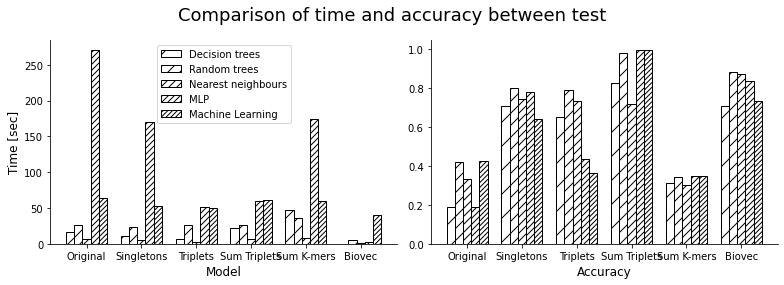

In [45]:
names = ["Original", "Singletons", "Triplets", "Sum Triplets", "Sum K-mers", "Biovec"]
tests = ["Decision trees", "Random trees", "Nearest neighbours", "MLP", "Machine Learning"]
print(all_times)
print(all_accs)
results_plot_benchmark(names, tests, all_times, all_accs)

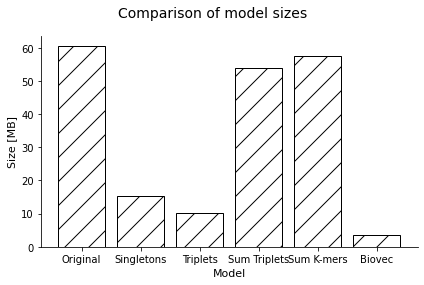

In [42]:
files = ["./data/clean_dataset_original.pkl",
         "./data/clean_dataset_singletons.pkl",
         "./data/clean_dataset_triplets.pkl",
         "./data/clean_dataset_sum_triplets.pkl",
         "./data/clean_dataset_sum_k_mers.pkl",
         "./data/clean_dataset_biovec.pkl"]

plot_sizes(files, names, "./presentation/images/sizes.png")